# 인물모드 제작 적용 및 문제점 해결

## Flow

![flow for photo focused](https://ifh.cc/g/hX5SZF.jpg)

### Deeplabv3+를 이용한 segmentation 이용

[reference](https://deep-learning-study.tistory.com/877)

![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FBIXSx%2Fbtrhh7vwNjH%2FA29CT1BaFsEYxcxNimCVxk%2Fimg.png)

 논문의 가장 큰 contribution은 ASPP module 입니다. 다양한 rate의 atrous conv를 적용해 multi-scale로부터 feature를 추출하여 concat 한 뒤에 1x1 conv로 전달하여 prediction을 수행합니다. ASPP module은 일반적인 CNN 모델 끝 단에 부착하여 사용합니다. 또한 atrous conv를 사용하여 더 깊은 레이어를 쌓는 실험을 합니다. feature map이 일정 크기 이하로 줄어들면, stride를 지닌 conv를 사용하여 down sampling하는 것이 아니라 매 block마다 atrous rate를 증가시켜 receptive field 를 증가합니다

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## Step 1. 인물모드 직접 해 보기

(4000, 6000, 3)


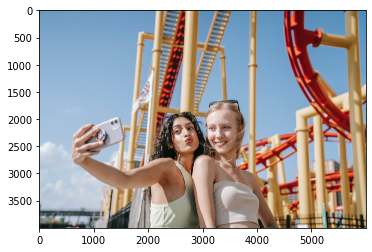

In [2]:
# img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
data_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
img_path = data_path+'test_selfie.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### (1)사람 검출을 위해 사전 학습된 model 호출

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f394b4a2160>)

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [5]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [6]:
LABEL_NAMES.index('person'),LABEL_NAMES.index('dog')

(15, 12)

### (2)이미지에서 blur 처리를 하고 mask 추출

In [11]:
def extract_human(img_path, ratio = 1,index = 15):
    segvalues, output = model.segmentAsPascalvoc(img_path)
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    seg_color = (colormap[index][-1],colormap[index][1],colormap[index][0]) # 15번째가 사람에 대한 vector
    seg_map = np.all(output==seg_color, axis=-1) 
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_mask_color= cv2.resize(img_mask_color, dsize=(0, 0), fx= ratio, fy= ratio, interpolation=cv2.INTER_LINEAR)
    
    return img_mask_color

In [8]:
def make_backgroud_mask(mask, img, show = True):
    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_mask = cv2.bitwise_not(mask)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_mask = cv2.bitwise_and(img, img_mask)
    if show:
        plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
        plt.show()
    return img_mask

In [9]:
def apply_blur(img_mask_color, img_orig, img_orig_blur,human = True, show = True):
    if human:
        img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)
    else: 
        img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur)
        
    if show:
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
        
    return img_concat

blur size: 1


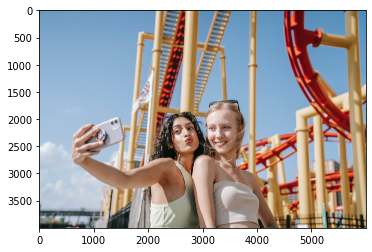

blur size: 13


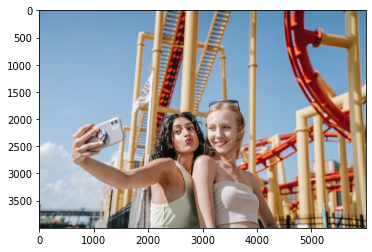

blur size: 30


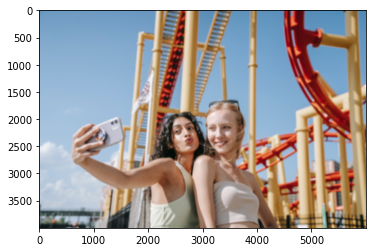

In [9]:
for blur in [1, 13, 30]: # 수치 별 blurring 정도 확인
    print('blur size:',blur)
    img_orig_blur = cv2.blur(img_orig, (blur,blur))

    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()


In [10]:
img_orig_blur = cv2.blur(img_orig, (30,30)) # blurring을 강하게 한 이미지로 적용

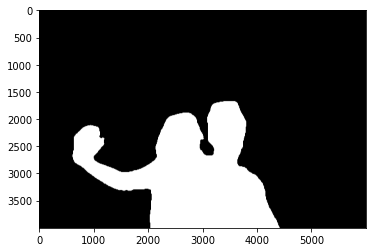

In [11]:
img_mask_color = extract_human(img_path)
plt.imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
plt.show()

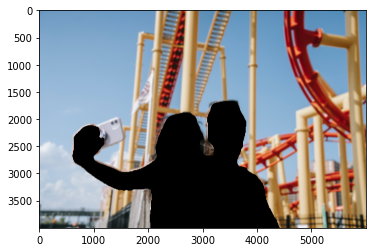

In [12]:
# blur_mask 추출
img_bg_blur = make_backgroud_mask(img_mask_color, img_orig_blur, show = True)

In [36]:
img_mask_color.shape[:2]

(4000, 6000)

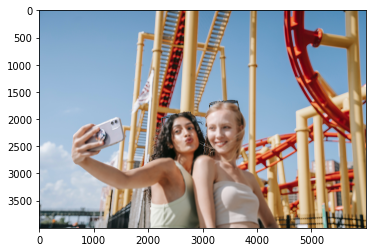

In [13]:
# 사람 blur 적용
img_concat_h = apply_blur(img_mask_color, img_orig, img_orig_blur,human = False, show = False)

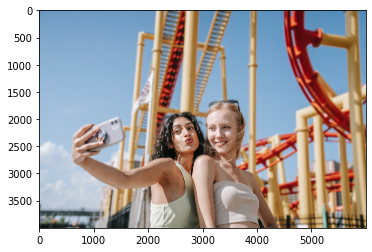

In [14]:
# 원본 사진에 blur이미지 적용
img_concat = apply_blur(img_mask_color, img_orig, img_orig_blur,human = True, show = False)

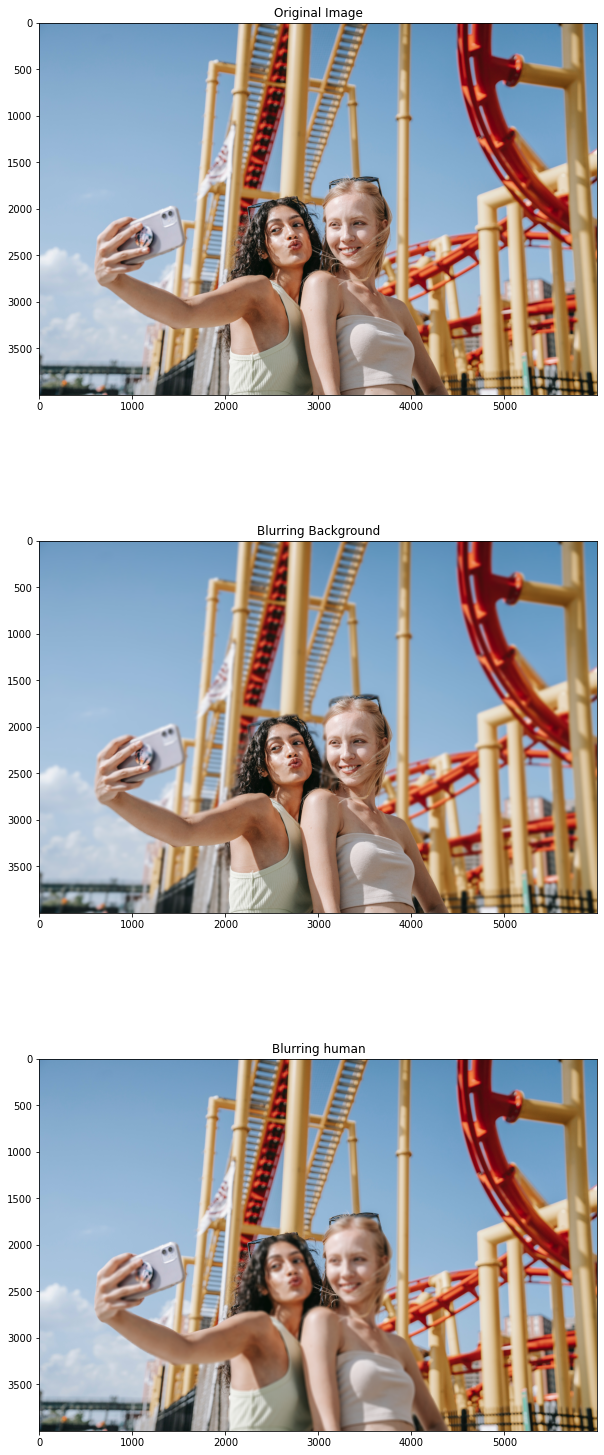

In [16]:
fig, ax = plt.subplots(3,1, figsize=(10,27))
ax[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax[1].set_title('Blurring Background')
ax[2].imshow(cv2.cvtColor(img_concat_h, cv2.COLOR_BGR2RGB))
ax[2].set_title('Blurring human')
plt.show()

##### mission 1. 동물 적용

(520, 780, 3)


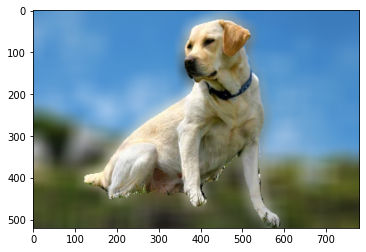

In [21]:
img_dog_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'  
img_dog_orig = cv2.imread(img_dog_path) 
print(img_dog_orig.shape)
img_dog_blur = cv2.blur(img_dog_orig, (blur,blur))
dog_mask_color = extract_human(img_dog_path, ratio = 1, index = 12) # dog 은 12번 
dog_concat = apply_blur(dog_mask_color, img_dog_orig, img_dog_blur)

##### mission 2,3. 배경 합성

In [12]:
img_path01 = os.getenv('HOME')+'/aiffel/human_segmentation/images/pexels-julia-m-cameron.jpg'  
img_orig01 = cv2.imread(img_path01) 
img01 = cv2.resize(img_orig01, dsize=(0, 0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR) # 사진 사이즈가 너무 커서 조정함
blur = 50
img_orig_blur01 = cv2.blur(img01, (blur,blur))
img_mask_color01 = extract_human(img_path01, ratio = 0.3) # mask도 사이즈 조정이 필요해서 ratio 기능 추가

img_concat01 = apply_blur(img_mask_color01, img01, img_orig_blur01,show = False) # 작게보여서 크게 출력할려고 show = False로 사용

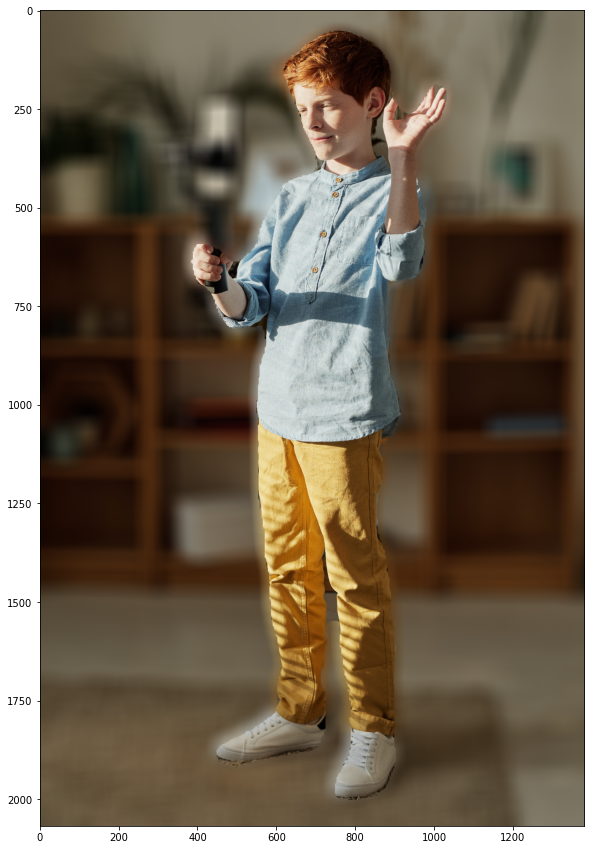

In [13]:
plt.figure(figsize = (10,15)) # 결과 출력
plt.imshow(cv2.cvtColor(img_concat01, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
img_concat01.shape

(2068, 1380, 3)

(748, 1280, 3)
(2068, 1380, 3)


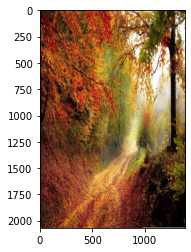

In [15]:
new_path = data_path+'new_background.jpg'  
back_orig = cv2.imread(new_path)
back = cv2.resize(back_orig, dsize=(1380,2068), interpolation=cv2.INTER_LINEAR) # 크기 맞춤

In [16]:
back_mask = extract_human(img_path01, ratio = 0.3)

In [22]:
merge = apply_blur(img_mask_color01, img01, back,show = False)

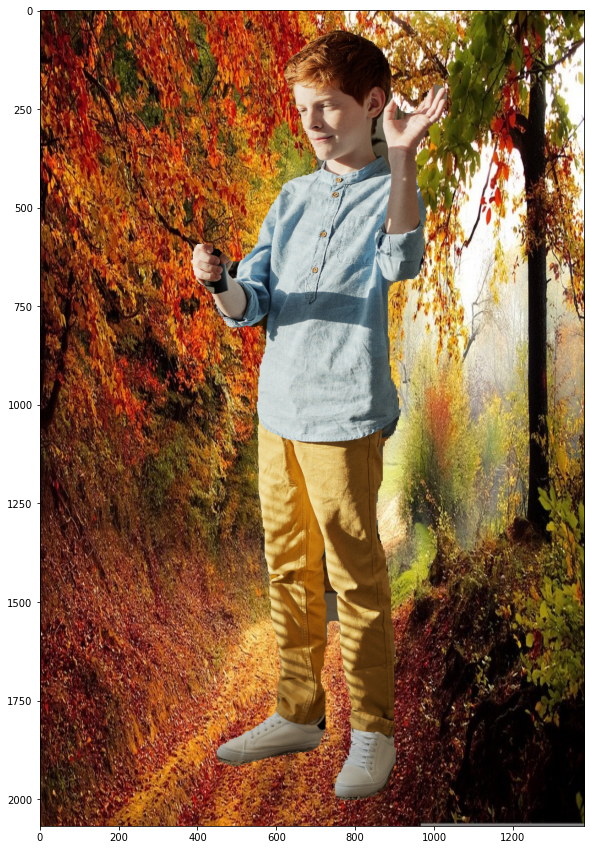

In [18]:
plt.figure(figsize = (10,15)) # 결과 출력
plt.imshow(cv2.cvtColor(merge, cv2.COLOR_BGR2RGB))
plt.show()

##### 기타 등등 적용해봄

In [19]:
img_path02 = os.getenv('HOME')+'/aiffel/human_segmentation/images/pexels-julie.jpg'  

img_orig02 = cv2.imread(img_path02) 
img02 = cv2.resize(img_orig02, dsize=(0, 0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)

img_orig_blur02 = cv2.blur(img02, (blur,blur))
img_mask_color02 = extract_human(img_path02, ratio = 0.3)

img_concat02 = apply_blur(img_mask_color02, img02, img_orig_blur02,show=  False)

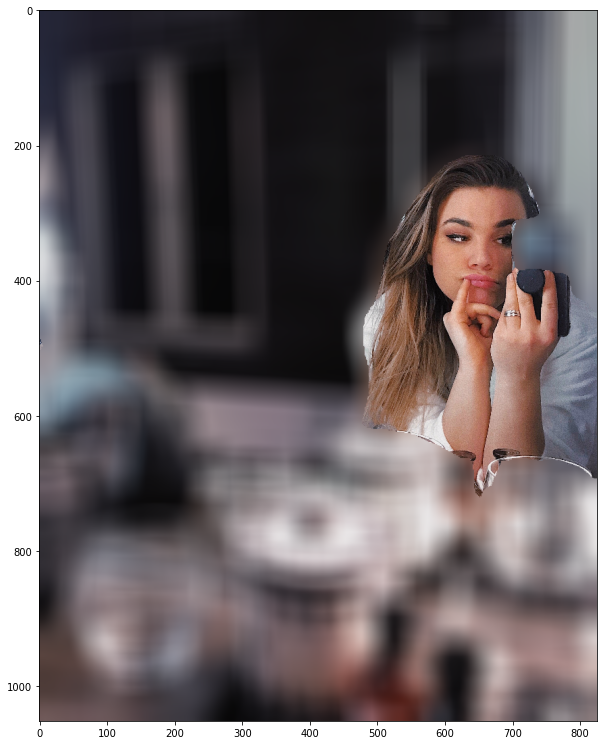

In [20]:
plt.figure(figsize = (10,15))
plt.imshow(cv2.cvtColor(img_concat02, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
img_path03 = os.getenv('HOME')+'/aiffel/human_segmentation/images/pexels-key-notez.jpg'  

img_orig03 = cv2.imread(img_path03) 
img03 = cv2.resize(img_orig03, dsize=(0, 0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)

img_orig_blur03 = cv2.blur(img03, (blur,blur))
img_mask_color03 = extract_human(img_path03, ratio = 0.3)

img_concat03 = apply_blur(img_mask_color03, img03, img_orig_blur03, show = False)

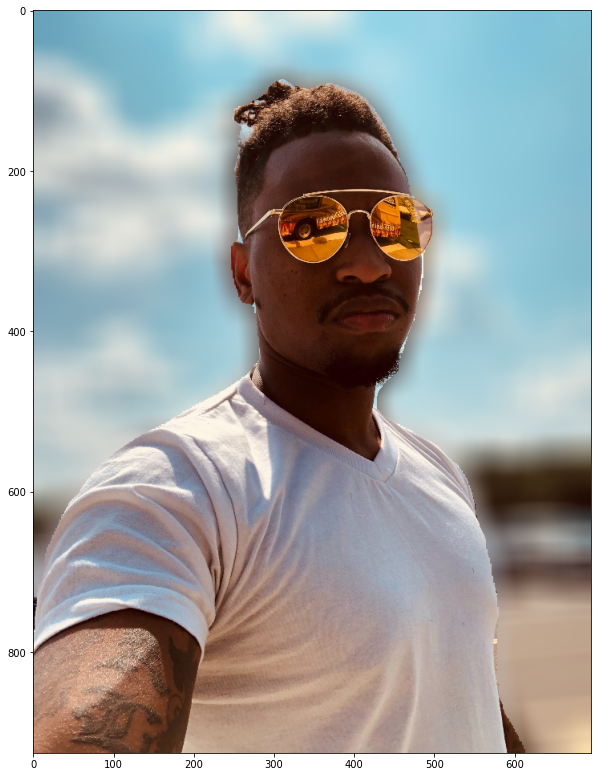

In [22]:
plt.figure(figsize = (10,15))
plt.imshow(cv2.cvtColor(img_concat03, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 2. 사진에서 문제점 찾기

![예시](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-13.max-800x600.png)

이와 같이 그림에서 문제점 표현하기

##### Results1


마지막 사진 빼고는 사람이 가지고 있는 물건에 대한 인식률이 좋지 않음

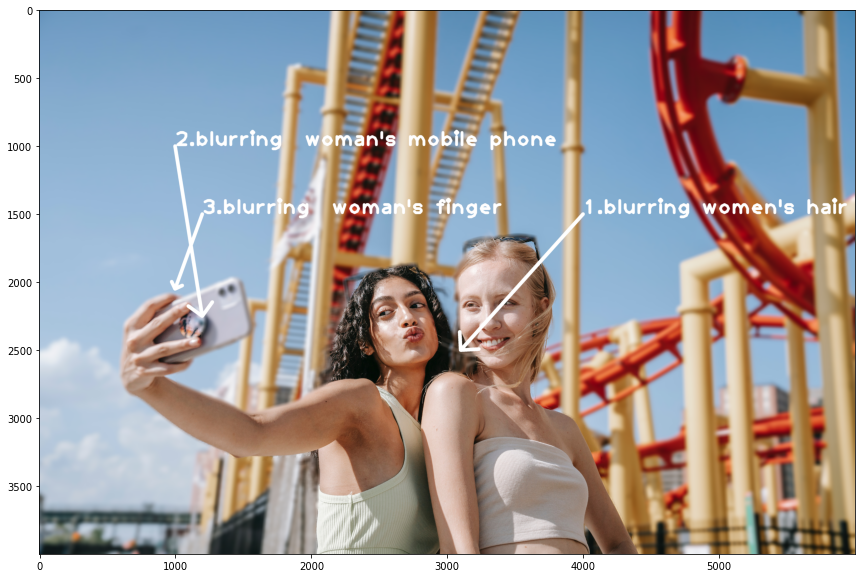

In [24]:
res0 = img_concat.copy()
plt.figure(figsize = (15,10))
cv2.arrowedLine(res0, (4000, 1500), (3100, 2500), (255,255,255), 25)
cv2.putText(res0, "1.blurring women's hair", (4000, 1500), cv2.FONT_HERSHEY_PLAIN, 10, (255,255,255), 20)  
cv2.arrowedLine(res0, (1000, 1000), (1200, 2250), (255,255,255), 25)
cv2.putText(res0, "2.blurring  woman's mobile phone", (1000, 1000), cv2.FONT_HERSHEY_PLAIN, 10, (255,255,255), 20)  
cv2.arrowedLine(res0, (1200, 1500), (1000, 2050), (255,255,255), 25)
cv2.putText(res0, "3.blurring  woman's finger", (1200, 1500), cv2.FONT_HERSHEY_PLAIN, 10, (255,255,255), 20)  
plt.imshow(cv2.cvtColor(res0, cv2.COLOR_BGR2RGB))
plt.show()

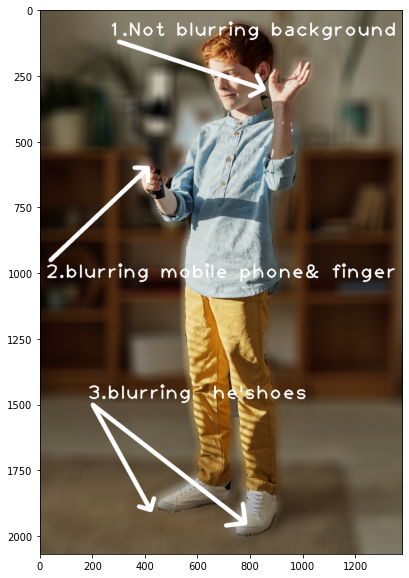

In [25]:
res1 = img_concat01.copy()
plt.figure(figsize = (15,10))
cv2.arrowedLine(res1, (300, 120), (850, 300), (255,255,255), 15)
cv2.putText(res1, "1.Not blurring background", (260, 100), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)  
cv2.arrowedLine(res1, (40, 950), (410, 600), (255,255,255), 15)
cv2.putText(res1, "2.blurring mobile phone& finger", (20, 1020), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)  
cv2.arrowedLine(res1, (200, 1500), (420, 1900), (255,255,255), 15)
cv2.arrowedLine(res1, (200, 1500), (780, 1950), (255,255,255), 15)
cv2.putText(res1, "3.blurring  he'shoes", (180, 1480), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)  
plt.imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB))
plt.show()

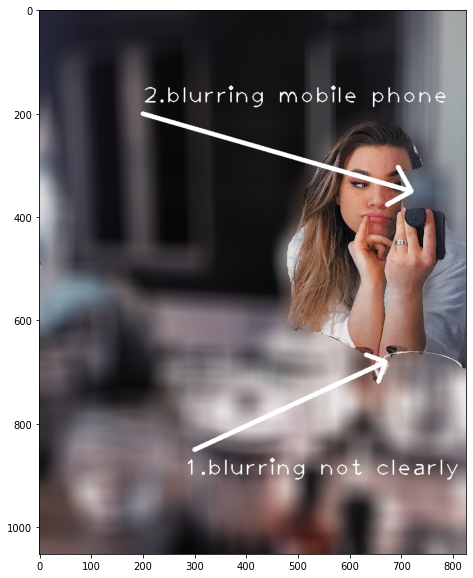

In [26]:
res2 = img_concat02.copy()
plt.figure(figsize = (15,10))
cv2.arrowedLine(res2, (300, 850), (670, 680), (255,255,255), 7)
cv2.putText(res2, "1.blurring not clearly", (280, 900), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 2)  
cv2.arrowedLine(res2, (200, 200), (720, 350), (255,255,255), 7)
cv2.putText(res2, "2.blurring mobile phone", (200, 180), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 2)  
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
plt.show()

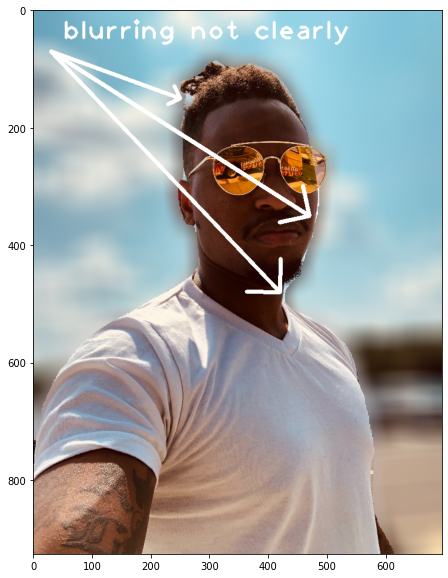

In [27]:
res3 = img_concat03.copy()
plt.figure(figsize = (15,10))
cv2.arrowedLine(res3, (30, 70), (250, 150), (255,255,255), 5)
cv2.arrowedLine(res3, (30, 70), (470, 350), (255,255,255), 5)
cv2.arrowedLine(res3, (30, 70), (420, 480), (255,255,255), 5)
cv2.putText(res3, "blurring not clearly", (50, 50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 3)  
plt.imshow(cv2.cvtColor(res3, cv2.COLOR_BGR2RGB))
plt.show()

## Step 3. 해결 방법을 제안해 보기

    - 이미지의 sharpness를 강조하기
    - Contrast 증가시키기
    - 다른 모델 사용하기
    
세 가지 방안을 테스트 해보았으나 
다른 모델을 사용하는 것 외에는 큰 효과를 보지 못함

##### 1.Sharpness

Text(0.5, 1.0, 'Sharp Image')

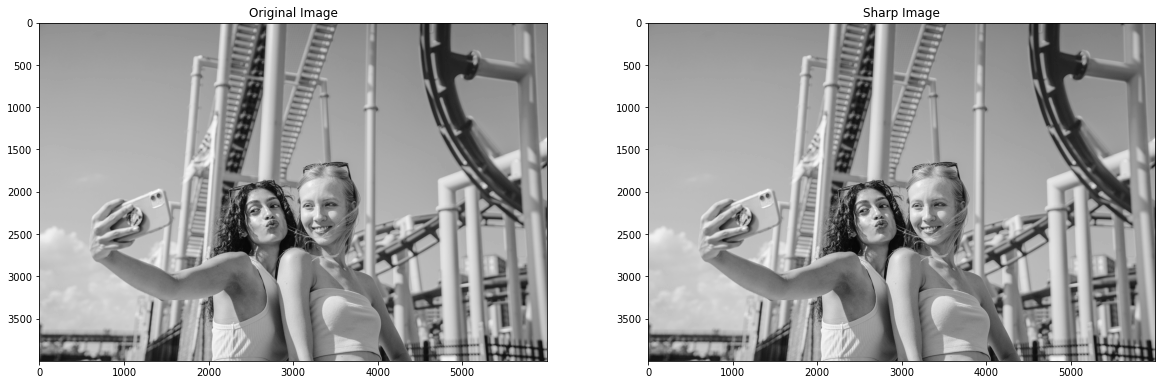

In [28]:
image = cv2.imread(data_path + 'test_selfie.jpg', cv2.IMREAD_GRAYSCALE)

# 커널 생성(대상이 있는 픽셀을 강조)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# 커널 적용 
image_sharp = cv2.filter2D(image, -1, kernel)

fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_sharp, cmap='gray')
ax[1].set_title('Sharp Image')

Text(0.5, 1.0, 'Sharp Image')

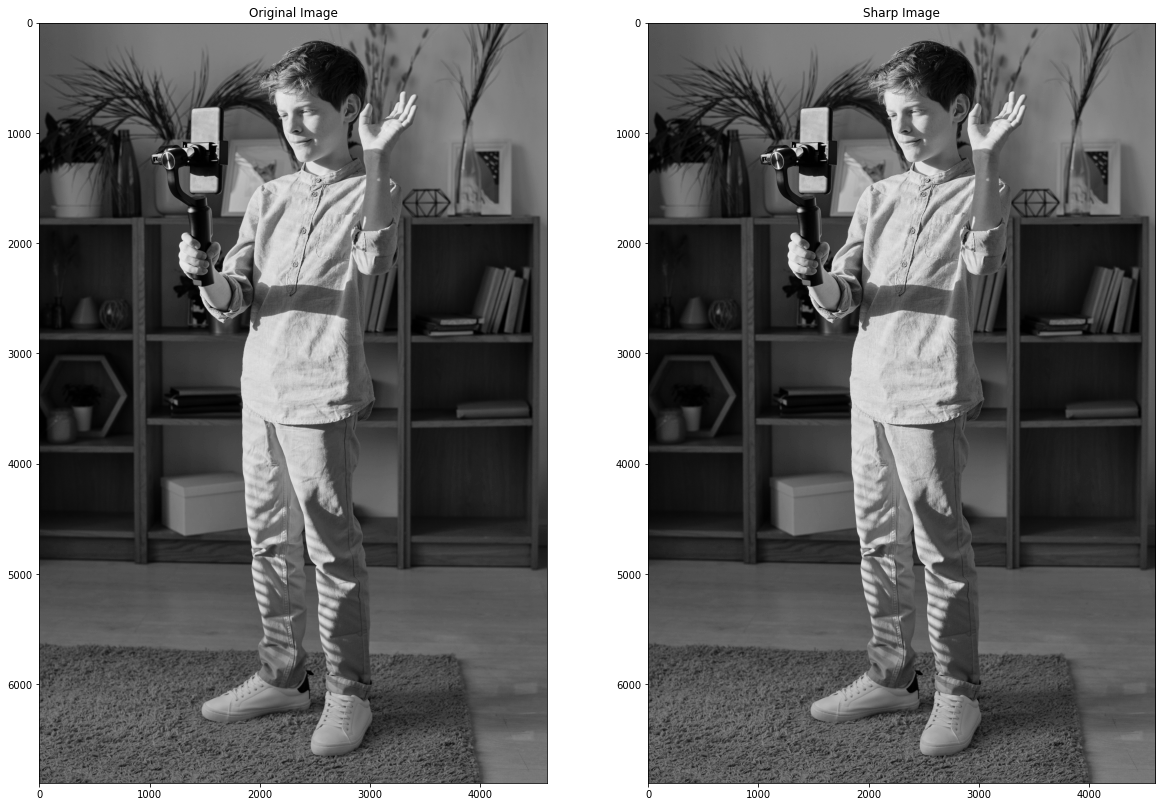

In [29]:
image = cv2.imread(data_path + 'pexels-julia-m-cameron.jpg', cv2.IMREAD_GRAYSCALE)

# 커널 생성(대상이 있는 픽셀을 강조)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# 커널 적용 
image_sharp = cv2.filter2D(image, -1, kernel)

fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_sharp, cmap='gray')
ax[1].set_title('Sharp Image')

다른 방식의 sharpning 기법을 적용해야할 것으로 보임 육안상으로는 크게 차이 없어서 contrast 기법으로 넘어감

##### 2. Contrast

In [30]:
def img_contrast(filename, con=3 ,show = True):
    image = cv2.imread(filename)#, cv2.IMREAD_GRAYSCALE)
    
    # -----Converting image to LAB Color model-----------------------------------
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # -----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    # -----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit= con, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    # -----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl, a, b))
    
    # -----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    cv2.imwrite(filename.split('.')[0]+'_contrast.png',final)
    
    if show :
        plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
        plt.show()

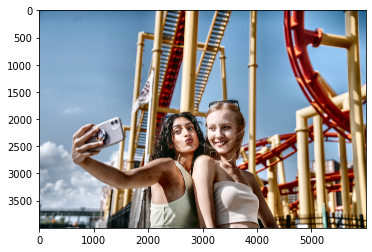

In [31]:
img_contrast(data_path + 'test_selfie.jpg')
test = extract_human(data_path + 'test_selfie_contrast.png')

Text(0.5, 1.0, 'Contrasted mask')

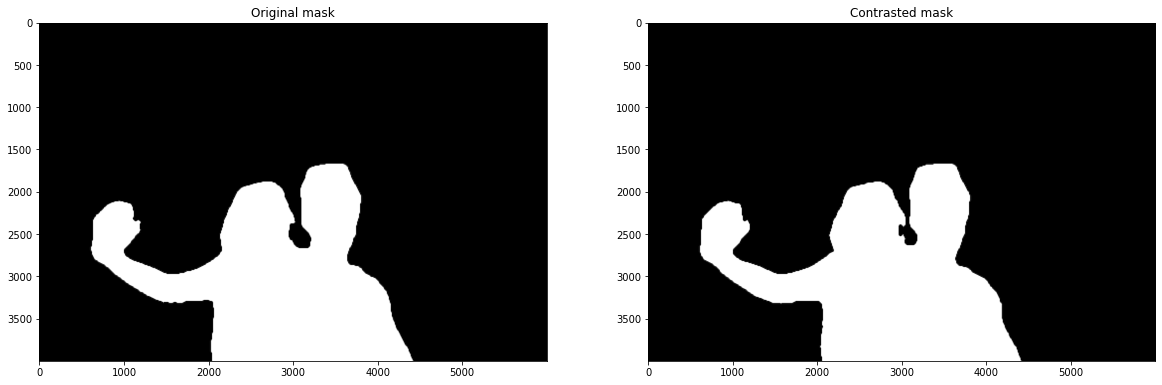

In [32]:
fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original mask')
ax[1].imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
ax[1].set_title('Contrasted mask')

약간 더 세밀하게 인식하는 것으로 보이지만 mask가 완전히 개선된 것으로 보이지 않음, 다른 방법을 찾아봄

##### Other model : MODNet


* Overview
1. Semantic estimation: a coarse foreground mask
2. Detail prediction: fine foreground boundaries
3. Semantic-detail fusion: blend the features

신경망은 복잡한 목표를 세분화할 경우 더 좋은 성능을 달성할 수 있다. 이에 MODNet은 Trimap-free semantic segmentation의 목표를 1. Semantic estimation, 2. Detail prediction, 3. Semantic-detail fusion 세 단계로 나눈다.

우선 Semantic estimation을 통해 거친 전경 마스크(Coarse foreground mask)을 예측하고, Detail prediction에서 세밀한 전경의 가장자리를 예측한다. 마지막으로 Semantic-detail fusion 단계는 이름처럼 두 하위 목표의 예측값인 Semantic과 Detail을 합쳐 최종 alpha matte 값을 예측한다.

[refernece](https://medium.com/ddiddu-log/modnet-is-a-green-screen-really-necessary-for-real-time-portrait-matting-%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0-e3eb27898b69)

![MODnet](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*PhuhHsWwNv902KtK0_ZITg.png)

이미지 segmentation 수행은 다음의 [github link](https://github.com/anilsathyan7/Portrait-Segmentation/blob/master/MODNet/modnet_video.ipynb)를 참고하였음 

segmentation 과는 아래와 같고 2에서 제시한 문제 부분에 대해 더 나은 성능을 보임

##### MODNet segmentation 결과1

    - 여자들 가운데의 머리카락이 인식 안되었었는데 이 부분 인식
    - 핸드폰 인식, 손가락도 명확하게 분리됨

![MODNet 결과 1](modnet_res01.png)

##### MODNet segmentation 결과2

    - 신발 부분이 깔끔하게 인식됨
    - 손가락까지는 깔끔하게 인식되었으나 그 상단의 핸드폰은 사람의 것으로 인식하지 않음

![MODNet 결과 2](modnet_res02.png)

## 회고

1. free selfie를 구하는 과정에서 이미 인물모드가 적용된 경우가 많아 적절한 사진을 찾기 힘들었음
2. 이미지 편집 기법의 부족으로 이미지의 윤곽선을 강조하는 다양한 방법을 적용해 보지 못했음
3. modnet 출처에서 제공했던 ipynb 자체를 공부하는 것이 다른 git 출처에서 모델을 불러와 사용하는 것에 대해 익숙해질 수 있을 것 같음
